In [ ]:

library(plyr)
library(tidyverse)
library(edgeR)
library(DESeq2)
library(MASS)
library(lattice)
library(GGally)
library(fastmatch)
library(pheatmap)
library(RColorBrewer)
library(dplyr)
library(reshape2)
library(viridis)
library(gplots)
library(knitr)
library(readr)
library(stringr)
library(GGally)
library(Rbowtie)
library(Rsamtools)
library(baRcodeR)
library(Seurat)
library(data.table)
library(ShortRead)
library(seqinr)
library(sctransform)
library(Rsubread)
library(DropletUtils)
library(ggrepel)
library(clusterProfiler)
library(org.Mm.eg.db)
library(ggbeeswarm)
library(ggpubr)


source("sc-funcs.R")
source("gene.sets.R")

In [11]:
sc <- readRDS("output_seurat/seurat_obj/seurat_pipeline_default_normalised_no_cc_regression.rds")
sc

An object of class Seurat 
21480 features across 1350 samples within 2 assays 
Active assay: SCT (10740 features, 3000 variable features)
 1 other assay present: RNA
 3 dimensional reductions calculated: pca, umap_30, tsne_30

In [ ]:
Idents(sc)<-sc@meta.data$Sample
DimPlot(sc, label = T, reduction = "tsne_30")
sc<- NormalizeData(
  sc,
  assay = "RNA",
  normalization.method = "RC",
  scale.factor = 1000000,
  margin = 1,
  verbose = TRUE,
  
)
sc

In [4]:
library(Seurat)
library(SingleCellExperiment)

#obj=readRDS("/g/data/zk16/qing/dawson/KRAS_T0_02_POST-DGE-analysis_diet.rds")

objsce <- as.SingleCellExperiment(sc)
objsce

class: SingleCellExperiment 
dim: 10740 1350 
metadata(0):
assays(2): counts logcounts
rownames(10740): Gnai3 Narf ... RP23-402P24.9 RP23-325D10.3
rowData names(0):
colnames(1350): X2323AAMSCB002 X2323AAMSCB003 ... X2346AAMSCB179
  X2346AAMSCB186
colData names(21): orig.ident nCount_RNA ... SCT_snn_res.1 ident
reducedDimNames(3): PCA UMAP_30 TSNE_30
altExpNames(0):

In [9]:
library(Seurat)
library(SingleCellExperiment)

#obj=readRDS("/g/data/zk16/qing/dawson/KRAS_T0_02_POST-DGE-analysis_diet.rds")

objsce <- as.SingleCellExperiment(sc)
counts <- assays(objsce)$counts #same as the data slot in the seurat object
libsizes <- colSums(counts)
size.factors <- libsizes/mean(libsizes)
logcounts(objsce) <- log2(t(t(counts)/size.factors) + 1)

exp <- as.matrix(assays(objsce)$logcounts)

meta <- colData(objsce)

testfiltergene <- function(cond) {
    sub_meta=subset(meta, Sample == cond )
    dat=exp[ , match(rownames(sub_meta), colnames(exp))]

    dat=t(dat) #feature on col, cell on row

    dat=scale(dat)#standadize data scale by col/feature

    colkeep=apply(dat, 2, function(x) all(!is.na(x))) # identify which columns (genes) dont contain NAs

    dat=dat[,colkeep]
    return(colnames(dat))
}

wt1 = testfiltergene('WT_UT')
rad1 = testfiltergene('RAD21_UT')
wt2 = testfiltergene('WT_2H')
rad2 = testfiltergene('RAD21_2H')
wt3 = testfiltergene('WT_8H')
rad3 = testfiltergene('RAD21_8H')
exp=exp[intersect(intersect(intersect(intersect(intersect(wt1, rad1), wt2), rad2), wt3), rad3),] 
                  
                  
                  
testCovgene <- function(cond) {
    sub_meta=subset(meta, Sample == cond)
    dat=exp[ , match(rownames(sub_meta), colnames(exp))]
    dat=t(dat) #feature on col, cell on row
    dat=scale(dat) #standadize data scale by col/feature
    print(cond)
    det=list()
    for (i in 1:50){ #permutation 
    set.seed(i)
    cellsample=sample(1:nrow(dat),100, replace=F) #sample cells to keep the same number of cell for both comb and kras

    genesample=sample(1:ncol(dat), 1000, replace=F) #take long time to run so could sample genes, I also tried with all genes and it shows similar trend but bigger difference 

    cdat = cov(dat[cellsample,genesample]) #calculate gene-gene covariance matrix using sampled genes
    #cdat = cov(dat[cellsample,genesample]) #calculate gene-gene covariance matrix using all genes 
    
    svddat=svd(cdat) #singular value decomposition 

    eigen=svddat$d #get the eigen value 

    eigen=eigen[eigen!=0]

    logV=sum(log(eigen)) #log sum of non-zero eigen values
#    logV=logV/length(genesample) #you could also norm by total number of genes 
    print(logV)
    det[[i]]=logV
    }

    return(det)
}

wt1pv=unlist(testCovgene('WT_UT'))
#wt2pv=unlist(testCovgene('WT_2H'))
#wt3pv=unlist(testCovgene('WT_8H'))
r1pv=unlist(testCovgene('RAD21_UT'))
#r2pv=unlist(testCovgene('RAD21_2H'))
#r3pv=unlist(testCovgene('RAD21_8H'))

                  
#setwd("/g/data/zk16/qing/dawson/")
#save(wt1pv, wt2pv, wt3pv,r1pv, r2pv, r3pv, file="testcovgenev2.RData")
save(wt1pv,r1pv, file="testcovgenev2.RData")



#then boxplot and stat tests
#plot
library(ggplot2)
library(ggpubr)
library(cowplot)

#plotdata<-data.frame(volume=c(wt1pv, wt2pv, wt3pv,r1pv, r2pv, r3pv),
                     #cell=c(rep(c("WT_UT","WT_2H","WT_8H","RAD21_UT","RAD21_2H","RAD21_8H"), times=c(length(wt1pv), length(wt2pv),length(wt3pv), length(r1pv), length(r2pv),length(r3pv)))))
head(plotdata)
dim(plotdata)

[1] "WT_UT"
[1] -30175.47
[1] -30184.94
[1] -30135.89
[1] -30077.34
[1] -30134.16
[1] -30053.87
[1] -30127.94
[1] -30191.26
[1] -30070.23
[1] -30076.98
[1] -30100.57
[1] -30169.76
[1] -30005.8
[1] -30188.78
[1] -30108.28
[1] -30066.69
[1] -30189.57
[1] -30137.13
[1] -29994.83
[1] -30125.65
[1] -30108.16
[1] -30206.81
[1] -30092.56
[1] -30081.78
[1] -30157.57
[1] -30172.27
[1] -30085.76
[1] -30012.28
[1] -30029.92
[1] -30152.47
[1] -30115.78
[1] -30161.69
[1] -30013.53
[1] -30136.98
[1] -30165.67
[1] -30189.64
[1] -30113
[1] -30084.95
[1] -30077.06
[1] -30115.53
[1] -30018.13
[1] -30114.69
[1] -30086.2
[1] -30094.22
[1] -30084.27
[1] -30196.59
[1] -30128.7
[1] -30190.88
[1] -30198.14
[1] -30184.67
[1] "WT_2H"
[1] -30200.62
[1] -30124
[1] -30142.73
[1] -30068.83
[1] -30144.87
[1] -30010.56
[1] -30149.28
[1] -30129.21
[1] -30098.01
[1] -30116.6
[1] -30056.86
[1] -30212.24
[1] -30099.14
[1] -30202.74
[1] -30036.24
[1] -30126.82
[1] -30071.86
[1] -30046.21
[1] -30090.78
[1] -30005.8
[1] -30

,volume,cell
,<dbl>,<chr>
1,-30175.47,WT_UT
2,-30184.94,WT_UT
3,-30135.89,WT_UT
4,-30077.34,WT_UT
5,-30134.16,WT_UT
6,-30053.87,WT_UT


[1] 300   2

Warning message:
“Computation failed in `stat_compare_means()`:
missing value where TRUE/FALSE needed”


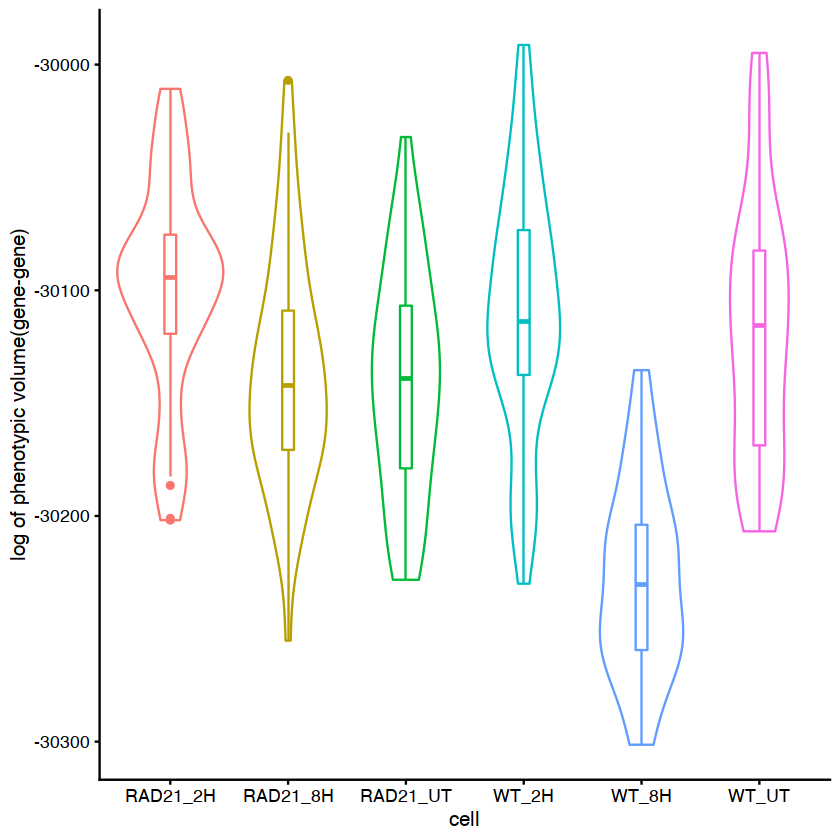

In [10]:
ggplot(plotdata, aes(x=cell, y=volume, color=cell))+geom_violin()+geom_boxplot(width=0.1)+
        #stat_compare_means()+ #this would give mann whitney test result
        theme_cowplot(12)+ylab("log of phenotypic volume(gene-gene)")+
        theme(legend.position="none") + 
        ggpubr::stat_compare_means(ref.group = "comb", method = "t.test", method.args = list(alternative = "less"))


write.csv(file = "PV.csv", plotdata)

,volume,cell
,<dbl>,<chr>
1,-30020.36,WT
2,-29946.12,WT
3,-30057.22,WT
4,-29939.62,WT
5,-29975.14,WT
6,-29864.47,WT


[1] 100   2

Warning message:
“Computation failed in `stat_compare_means()`:
missing value where TRUE/FALSE needed”


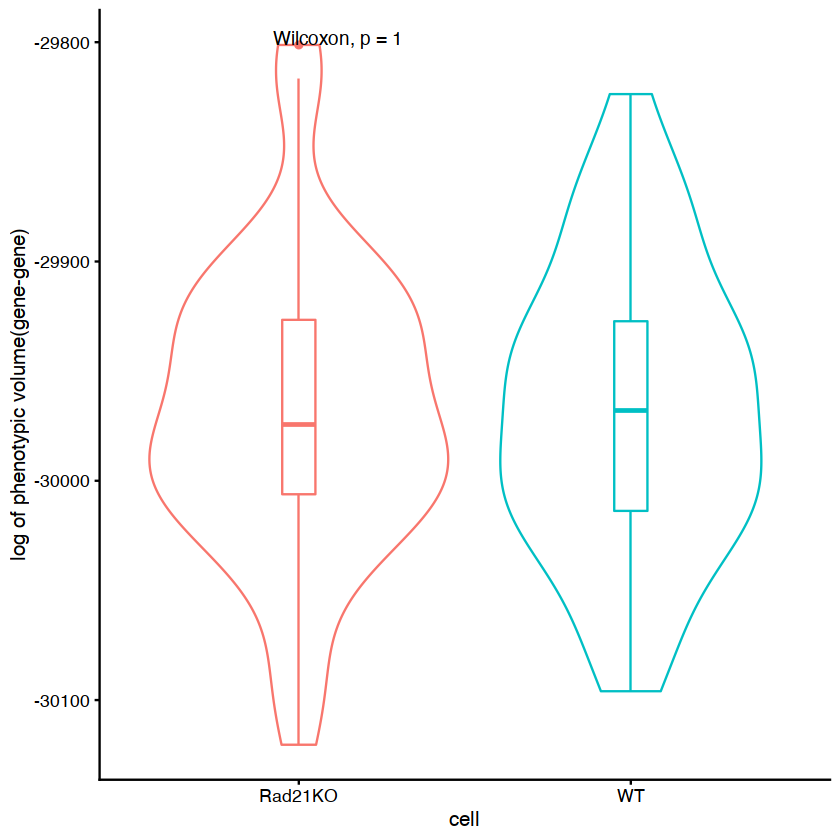

In [7]:
library(infotheo)
library(Seurat)
library(SingleCellExperiment)
objsce<-as.SingleCellExperiment(sc)
exp<-as.matrix(assays(objsce)$counts) 
meta<-colData(objsce)

plotdata<-data.frame(volume=c(wt1pv,r1pv),
		     cell=c(rep(c("WT","Rad21KO"), times=c(length(wt1pv), length(r1pv)))))

head(plotdata)
dim(plotdata)

ggplot(plotdata, aes(x=cell, y=volume, color=cell))+geom_violin()+geom_boxplot(width=0.1)+
        stat_compare_means()+ #this would give mann whitney test result
        theme_cowplot(12)+ylab("log of phenotypic volume(gene-gene)")+
        theme(legend.position="none") + 
        ggpubr::stat_compare_means(ref.group = "comb", method = "t.test", method.args = list(alternative = "less"))



In [8]:
#------------------------------------------------------------------------------------
# KRAS Baseline Analysis - NMI analysis
#------------------------------------------------------------------------------------
```{r}
#library anad data
library(infotheo)
library(Seurat)
library(SingleCellExperiment)

obj=readRDS("/g/data/zk16/qing/dawson/KRAS_T0_02_POST-DGE-analysis_diet.rds")

objsce<-as.SingleCellExperiment(obj)
exp<-as.matrix(assays(objsce)$counts) 
meta<-colData(objsce)



source("/home/114/qw3309/dawson/final/NMI_function_1k_replace.R")


kras=unlist(testNMIcell('KRAS_winner'))
comb=unlist(testNMIcell('RATIO_winner'))

setwd("/g/data/zk16/qing/dawson/final/")
save(kras, comb, file="testnmi_cellv2_1k_replace.RData")


#plot
library(ggplot2)
library(ggpubr)
library(cowplot)

#load("testnmi.RData")
plotdata<-data.frame(volume=c(kras,comb),
		     cell=c(rep(c("kras","comb"), times=c(length(kras), length(comb)))))
head(plotdata)
dim(plotdata)

ggplot(plotdata, aes(x=cell, y=volume, color=cell))+geom_violin()+geom_boxplot(width=0.1)+
        #stat_compare_means()+
        theme_cowplot(12)+ylab("Normalized Mutual Information(NMI)")+
        theme(legend.position="none")
ggsave("kras_v_comb_NMI_cellv2_1k_replace.pdf")


#P VALUE
setwd("/g/data/zk16/qing/dawson/final/")
compare<-matrix(0, nrow=length(kras), ncol=length(comb))
for (i in 1:length(kras)){
	for (j in 1:length(comb)){
		compare[i,j]<-kras[i]-comb[j]
	}}
p=(sum(compare<0)+1)/(length(kras)*length(comb)+1)
print("p value is")
print(p)
#0.2683437

#distribution 
library(ggplot2)
library(cowplot)
plotdata=as.data.frame(as.numeric(compare))
colnames(plotdata)='compare'
ggplot(plotdata, aes(x=compare))+geom_density()+geom_vline(aes(xintercept=0),color="red", linetype="dashed", size=1)+ggtitle('permutation result of NMI comparison (kras vs comb) p=0.27')+theme_cowplot(12)
ggsave('kras_v_comb_NMI_1k_pvalue_replace.pdf')

wilcox.test(kras, comb)
#p-value < 2.2e-16
wilcox.test(kras, comb, alternative="greater")
# p-value < 2.2e-16
```

ERROR: Error in parse(text = x, srcfile = src): attempt to use zero-length variable name


In [ ]:
clone.idents <- data.frame(idents = as.factor(seq(0,max(as.numeric(KRAS.T0@meta.data$SCT_snn_res.0.65))-1,1)))
for(x in clone.counts$barcode){
  print(x)
  clone <- filter(KRAS.T0@meta.data, barcode == x)
  idents <- clone$SCT_snn_res.0.65
  idents.table <- data.frame(table(idents))
  #idents.table$idents <- as.integer(idents.table$idents)
  colnames(idents.table) <- c("idents", as.character(x))
  clone.idents <- left_join(clone.idents, idents.table, by = "idents")
}

rownames(clone.idents) <- clone.idents$idents
clone.idents$idents <- NULL
clone.idents
```


```{r}

df = t(clone.idents+1)

boot_out_kras <- boot(df[1,], shannon_boot, R=1000)

boot_out_combo <- boot(df[2,], shannon_boot, R=1000)

boot.ci(boot_out_kras, index=1)
boot.ci(boot_out_combo, index=1)

sig <- wilcox.test( boot_out_kras$t, boot_out_combo$t)

clone.dists <- data.frame(iter = seq(1,1000,1))
for(clone in rownames(df)){
  dat <- as.data.frame(boot(df[as.character(clone),], shannon_boot, R=1000)$t)
  colnames(dat) <- as.character(clone)
  dat$iter <- seq(1,1000,1)
  clone.dists <- left_join(clone.dists, dat)
}
clone.dists
rownames(clone.dists) <- clone.dists$iter
clone.dists$iter <- NULL

pdf("~/Desktop/KF09_results/kras_combo_specific_resampling_shannon_boxplot.pdf", width = 4, height = 2, useDingbats = F)
library(tidyverse)
clone.dists %>% reshape2::melt() %>% ggplot(aes(x = variable, y = value)) +
  geom_boxplot(fill = viridis(ncol(clone.dists))) + theme_bw() + coord_flip() +
  ggtitle(paste("Mann Whitney U: P =",signif(sig$p.value, 3)))
dev.off()
```

In [ ]:

## Setup environment
```{r setup env, message=FALSE, warning=FALSE}
## import packages ----------------------------------------------------------------------------------------------------
library(plyr)
library(tidyverse)
library(edgeR)
library(DESeq2)
library(MASS)
library(lattice)
library(GGally)
library(fastmatch)
library(pheatmap)
library(RColorBrewer)
library(dplyr)
library(reshape2)
library(viridis)
library(gplots)
library(knitr)
library(readr)
library(stringr)
library(GGally)
library(Rbowtie)
library(Rsamtools)
library(barcodeR)
library(Seurat)
library(data.table)
library(ShortRead)
library(seqinr)
library(sctransform)
library(Rsubread)
library(DropletUtils)
library(ggrepel)
library(clusterProfiler)
library(org.Mm.eg.db)
library(ggbeeswarm)
library(ggpubr)
#library(EnhancedVolcano)
#source("~/my_scripts/singlecell/seurat_analysis.R")
source("~/my_scripts/singlecell/sc-funcs.R")
source("~/my_scripts/singlecell/gene.sets.R")

## setup environment ----------------------------------------------------------------------------------------------------
setwd("/dawson_genomics/Projects/Barcode/KF09_Clonal_competition/analysis/KF09_scRNA-seq/")

# MLL dirs
MLL.dir <- file.path(getwd(), "MLL_results")
dir.create(MLL.dir, showWarnings = F)
MLL.plots.dir <- file.path(MLL.dir, "plots")
dir.create(MLL.plots.dir, showWarnings = F)
MLL.results.dir <- file.path(MLL.dir, "results")
dir.create(MLL.results.dir, showWarnings = F)

# KRAS dirs
KRAS.dir <- file.path(getwd(), "KRAS_results")
dir.create(KRAS.dir, showWarnings = F)
KRAS.plots.dir <- file.path(KRAS.dir, "plots")
dir.create(KRAS.plots.dir, showWarnings = F)
KRAS.results.dir <- file.path(KRAS.dir, "results")
dir.create(KRAS.results.dir, showWarnings = F)

# FLT3 dirs
FLT3.dir <- file.path(getwd(), "FLT3_results")
dir.create(FLT3.dir, showWarnings = F)
FLT3.plots.dir <- file.path(FLT3.dir, "plots")
dir.create(FLT3.plots.dir, showWarnings = F)
FLT3.results.dir <- file.path(FLT3.dir, "results")
dir.create(FLT3.results.dir, showWarnings = F)

# OPTIONS
threads <- 8 # number of threads to use for 10X cell barcode annotation

# reference barcode library
mCHERRY.ref <- "~/my_scripts/snakemake-pipelines/barcode-seq_pipeline/refs/mCHERRY_redesign_reference_library/mCHERRY_2_barcode_reference_library.fasta"
GFP.ref <- "~/my_scripts/snakemake-pipelines/barcode-seq_pipeline/refs/GFP_reference_library/GFP_barcode_reference_library.fasta"
BFP.ref <- "~/my_scripts/snakemake-pipelines/barcode-seq_pipeline/refs/BFP_reference_library/BFP_barcode_reference_library.fasta"

# define barcode library indexes
mCHERRY.idx <- "/home/dvassiliadis/my_scripts/snakemake-pipelines/barcode-seq_pipeline/refs/mCHERRY_redesign_reference_library/bowtie/mCHERRY_2_barcode"
GFP.idx <- "/home/dvassiliadis/my_scripts/snakemake-pipelines/barcode-seq_pipeline/refs/GFP_reference_library/bowtie/GFP_barcode"
BFP.idx <- "/home/dvassiliadis/my_scripts/snakemake-pipelines/barcode-seq_pipeline/refs/BFP_reference_library/bowtie/BFP_barcode"

# define barcode regex patterns
GFP.full.pattern <- "GATCCTGACCATGTACGATTGACTA([ACTG][ACTG][GC][AT][GC][ACTG][ACTG][AT][GC][AT]){6}TGCTAATGCGTACTGACTAGGCTAG"
BFP.full.pattern <- "GATCCTGACCATGTACGATTGACTA([ACTG][ACTG][AT][GC][AT][ACTG][ACTG][GC][AT][GC]){6}TGCTAATGCGTACTGACTAGGCTAG"
mCH.full.pattern <- "GATCCTGACCATGTACGATTGACTA([ACTG][AT][ACTG][GC][ACTG][AT][ACTG][GC][ACTG][AT][ACTG][GC]){5}TGCTAATGCGTACTGACTAGGCTAG"

GFP.short.up.pattern.3to6 <- "CGATTGACTA([ACTG][ACTG][GC][AT][GC][ACTG][ACTG][AT][GC][AT]){3,6}"
BFP.short.up.pattern.3to6 <- "CGATTGACTA([ACTG][ACTG][AT][GC][AT][ACTG][ACTG][GC][AT][GC]){3,6}"
mCH.short.up.pattern.2to5 <- "CGATTGACTA([ACTG][AT][ACTG][GC][ACTG][AT][ACTG][GC][ACTG][AT][ACTG][GC]){2,5}"

short.up.pattern <- "(CGATTGACTA)[ACTG]{10,60}"
up.pattern <- "(TGACCATGTACGATTGACTA)[ACTG]{10,60}"

s.genes <- readLines("../../scripts/s.genes.txt")
g2m.genes <- readLines("../../scripts/g2m.genes.txt")
cell.cycle.genes <- list(s.genes = s.genes, g2m.genes = g2m.genes)

# set a RNG seed value
set.seed(10101)
```

## Load Preprocessed Datasets
```{r load preprocessed seurat objects}
# KRAS T0
KRAS.T0 <- readRDS(file.path(KRAS.dir,"seurat_obj","KRAS_T0_cc_regressed_normalised_metadata-added_final.rds"))
```


```{r}
DimPlot(MLL.T0, label = T, reduction = "umap50")
DimPlot(FLT3.T0, label = T, reduction = "umap50")
Idents(KRAS.T0) <- "SCT_snn_res.0.65"
DimPlot(KRAS.T0, label = T, reduction = "umap50")
```


#------------------------------------------------------------------
# KRAS Baseline Analysis - Emily Wong Shannon Diversity per clone
#------------------------------------------------------------------

## get clustering information for each clone
```{r}
clone.counts <- KRAS.T0@meta.data[,c("barcode","result.3"), drop = F] %>% 
  filter(barcode != "not.detected") %>% 
  group_by(barcode, result.3) %>% 
  tally(sort = T) %>%
  filter(n > 20)

head(clone.counts)
```

## plot clustering profiles for individual clones in each group
```{r}
# get groups of clones
unique(clone.counts$result.3)
baseline.dominant <- clone.counts %>% filter(result.3 == "T0_winner")
KRAS.dominant <- clone.counts %>% filter(result.3 == "KRAS_winner")
COMP.dominant <- clone.counts %>% filter(result.3 == "RATIO_winner")
losers <- clone.counts %>% filter(result.3 == "loser")
```

```{r}
# baseline dominant
lapply(baseline.dominant$barcode, function(x){DimPlot(KRAS.T0, reduction = "umap50", cells.highlight = rownames(KRAS.T0@meta.data[which(KRAS.T0@meta.data$barcode == as.character(x)),]), sizes.highlight = 2) + ggtitle(x)})
```

```{r}
# KRAS dominant
lapply(KRAS.dominant$barcode, function(x){DimPlot(KRAS.T0, reduction = "umap50", cells.highlight = rownames(KRAS.T0@meta.data[which(KRAS.T0@meta.data$barcode == as.character(x)),]), sizes.highlight = 2) + ggtitle(x)})
```

```{r}
# COMP dominant
lapply(COMP.dominant$barcode, function(x){DimPlot(KRAS.T0, reduction = "umap50", cells.highlight = rownames(KRAS.T0@meta.data[which(KRAS.T0@meta.data$barcode == as.character(x)),]), sizes.highlight = 2) + ggtitle(x)})
```

```{r}
# losers
lapply(losers$barcode, function(x){DimPlot(KRAS.T0, reduction = "umap50", cells.highlight = rownames(KRAS.T0@meta.data[which(KRAS.T0@meta.data$barcode == as.character(x)),]), sizes.highlight = 2) + ggtitle(x)})
```


## calculate shannon diversity per clone
```{r}
library(Seurat)
library(boot)
library(ineq)
set.seed(10101)
library(vegan)

shannon_boot = function(data, indices) {
  dt <- data[indices]
  S = length(data) ## Total number of clusters 
  H = 0 
  Tot.obs = sum(dt)
  for (j in 1:S){
    H[j] = ((dt[j])/Tot.obs)*log((dt[j])/Tot.obs)
    }
  Hprime = -sum(H)
  return (Hprime)
}

Idents(KRAS.T0) <- "SCT_snn_res.0.65"
DimPlot(KRAS.T0, label = T, reduction = "umap50")

```

## get cluster identities per barcode
```{r}
clone.idents <- data.frame(idents = as.factor(seq(0,max(as.numeric(KRAS.T0@meta.data$SCT_snn_res.0.65))-1,1)))
for(x in clone.counts$barcode){
  print(x)
  clone <- filter(KRAS.T0@meta.data, barcode == x)
  idents <- clone$SCT_snn_res.0.65
  idents.table <- data.frame(table(idents))
  #idents.table$idents <- as.integer(idents.table$idents)
  colnames(idents.table) <- c("idents", as.character(x))
  clone.idents <- left_join(clone.idents, idents.table, by = "idents")
}
rownames(clone.idents) <- clone.idents$idents
clone.idents$idents <- NULL
clone.idents
```


```{r}

df = t(clone.idents+1)

boot_out_kras <- boot(df[1,], shannon_boot, R=1000)

boot_out_combo <- boot( df[2,], shannon_boot, R=1000)

boot.ci(boot_out_kras, index=1)
boot.ci(boot_out_combo, index=1)

sig <- wilcox.test( boot_out_kras$t, boot_out_combo$t)

clone.dists <- data.frame(iter = seq(1,1000,1))
for(clone in rownames(df)){
  dat <- as.data.frame(boot(df[as.character(clone),], shannon_boot, R=1000)$t)
  colnames(dat) <- as.character(clone)
  dat$iter <- seq(1,1000,1)
  clone.dists <- left_join(clone.dists, dat)
}
clone.dists
rownames(clone.dists) <- clone.dists$iter
clone.dists$iter <- NULL

pdf("~/Desktop/KF09_results/kras_combo_specific_resampling_shannon_boxplot.pdf", width = 4, height = 2, useDingbats = F)
library(tidyverse)
clone.dists %>% reshape2::melt() %>% ggplot(aes(x = variable, y = value)) +
  geom_boxplot(fill = viridis(ncol(clone.dists))) + theme_bw() + coord_flip() +
  ggtitle(paste("Mann Whitney U: P =",signif(sig$p.value, 3)))
dev.off()
```

```{r}
KRAS.idents <- KRAS.T0@meta.data[,c("barcode", "SCT_snn_res.0.65")]
KRAS.specific = subset(clone.counts, result.3 == 'KRAS_winner') %>% left_join(KRAS.idents, by = "barcode")
COMBO.specific = subset(clone.counts, result.3 == 'RATIO_winner') %>% left_join(KRAS.idents, by = "barcode")
baseline.specific = subset(clone.counts, result.3 == 'T0_winner') %>% left_join(KRAS.idents, by = "barcode") 
loser.specific = subset(clone.counts, result.3 == 'loser') %>% left_join(KRAS.idents, by = "barcode")  
all.clones = clone.counts %>% left_join(KRAS.idents, by = "barcode")

KRAS.idents %>% group_by(SCT_snn_res.0.65, barcode) %>% tally()
data.frame(table(KRAS.idents))
```

#------------------------------------------------------------------------------------
# KRAS Baseline Analysis - Phenotypic Volume
#------------------------------------------------------------------------------------

## Phenotypic volume - KRAS-T0
## from this paper - https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6348010/#S14
```{r}
# testing whether there is a change in PV between kras and comb cells
library(Seurat)
library(SingleCellExperiment)

#obj=readRDS("/g/data/zk16/qing/dawson/KRAS_T0_02_POST-DGE-analysis_diet.rds")

objsce <- as.SingleCellExperiment(KRAS.T0)
exp <- as.matrix(assays(objsce)$logcounts) #same as the data slot in the seurat object
meta <- colData(objsce)

testfiltergene <- function(cond) {
    sub_meta=subset(meta, result.3 == cond )
    dat=exp[ , match(rownames(sub_meta), colnames(exp))]

    dat=t(dat) #feature on col, cell on row

    dat=scale(dat)#standadize data scale by col/feature

    colkeep=apply(dat, 2, function(x) all(!is.na(x))) # identify which columns (genes) dont contain NAs

    dat=dat[,colkeep]
    return(colnames(dat))
}

kras = testfiltergene('KRAS_winner')
comb = testfiltergene('RATIO_winner')
length(kras)
length(comb)
exp=exp[intersect(kras, comb),] 


testCovgene <- function(cond) {
    sub_meta=subset(meta, result.3 == cond )
    dat=exp[ , match(rownames(sub_meta), colnames(exp))]
    dat=t(dat) #feature on col, cell on row
    dat=scale(dat) #standadize data scale by col/feature

    det=list()
    for (i in 1:50){ #permutation 
    set.seed(i)
    cellsample=sample(1:nrow(dat),100, replace=F) #sample cells to keep the same number of cell for both comb and kras

    genesample=sample(1:ncol(dat), 1000, replace=F) #take long time to run so could sample genes, I also tried with all genes and it shows similar trend but bigger difference 

    cdat = cov(dat[cellsample,genesample]) #calculate gene-gene covariance matrix using sampled genes
    #cdat = cov(dat[cellsample,genesample]) #calculate gene-gene covariance matrix using all genes 
    
    svddat=svd(cdat) #singular value decomposition 

    eigen=svddat$d #get the eigen value 

    eigen=eigen[eigen!=0]

    logV=sum(log(eigen)) #log sum of non-zero eigen values
#    logV=logV/length(genesample) #you could also norm by total number of genes 
    print(logV)
    det[[i]]=logV
    }

    return(det)
}

kras=unlist(testCovgene('KRAS_winner'))
comb=unlist(testCovgene('RATIO_winner'))

setwd("/dawson_genomics/Projects/Barcode/KF09_Clonal_competition/analysis/KF09_scRNA-seq/")
#setwd("/g/data/zk16/qing/dawson/")
save(kras, comb, file="testcovgenev2.RData")

#then boxplot and stat tests
#plot
library(ggplot2)
library(ggpubr)
library(cowplot)

plotdata<-data.frame(volume=c(kras,comb),
                     cell=c(rep(c("kras","comb"), times=c(length(kras), length(comb)))))
head(plotdata)
dim(plotdata)

ggplot(plotdata, aes(x=cell, y=volume, color=cell))+geom_violin()+geom_boxplot(width=0.1)+
#        stat_compare_means()+ #this would give mann whitney test result
        theme_cowplot(12)+ylab("log of phenotypic volume(gene-gene)")+
        theme(legend.position="none") + 
        ggpubr::stat_compare_means(ref.group = "comb", method = "t.test", method.args = list(alternative = "less"))
ggsave("kras_v_comb_PV_genev2.pdf")

#P VALUE
compare <- matrix(0, nrow=length(kras), ncol=length(comb))
for (i in 1:length(kras)){
        for (j in 1:length(comb)){
                compare[i,j]<-kras[i]-comb[i]
        }}
p=(sum(compare<0)+1)/(length(kras)*length(comb)+1)

print("p value is")
print(p)


```

## phenotypic volume per clone - KRAS
```{r}
objsce <- as.SingleCellExperiment(KRAS.T0)
exp <- as.matrix(assays(objsce)$logcounts) #same as the data slot in the seurat object
meta <- colData(objsce)

# get a list of all clones in experiment
clones <- unlist(KRAS.T0@meta.data %>% group_by_("barcode") %>% tally() %>% arrange(desc(n)) %>% filter(n >= 20) %>% dplyr::select(barcode))
clones <- as.character(clones[2:length(clones)])

KRAS.dominant <- c("BFP_Barcode_505045","BFP_Barcode_414176","BFP_Barcode_421454","BFP_Barcode_100420","BFP_Barcode_354313","BFP_Barcode_33250","BFP_Barcode_306435","BFP_Barcode_84237","BFP_Barcode_148963","BFP_Barcode_76877","BFP_Barcode_40849","BFP_Barcode_533119","BFP_Barcode_41609","BFP_Barcode_106142","BFP_Barcode_565785","BFP_Barcode_23619","BFP_Barcode_128508","BFP_Barcode_42121","BFP_Barcode_206178","BFP_Barcode_142893","BFP_Barcode_4531","BFP_Barcode_36237")

KRAS.dominant <- clones[which(KRAS.dominant %in% clones)]

KRAS.clones <- unique(KRAS.T0$barcode)
KRAS.loser <- which(clones %in% KRAS.dominant)
KRAS.clones <- clones[-KRAS.loser]
set.seed(10101)
KRAS.loser <- sample(clones, size = 15, replace = F)

# function to get normalised expression data from each group
testfiltergene <- function(cond) {
    sub_meta=subset(meta, barcode == cond ) # note the change of result.3 to barcode here to look on a per clone basis
    dat=exp[ , match(rownames(sub_meta), colnames(exp))]

    dat=t(dat) #feature on col, cell on row

    dat=scale(dat)#standadize data scale by col/feature

    colkeep=apply(dat, 2, function(x) all(!is.na(x))) # identify which columns (genes) dont contain NAs

    dat=dat[,colkeep]
    return(colnames(dat))
}

clones.to.test <- c(KRAS.dominant,as.character(KRAS.loser))

# use above function to extract expression data for genes expressed in all clones
all.clones.gene = lapply(clones.to.test, function(x) testfiltergene(x))
names(all.clones.gene) <- clones.to.test
length(all.clones.gene)

# Reduce function allows multiple intersect calls across all clones
exp = exp[Reduce(intersect, all.clones.gene),] 

testCovgene <- function(cond) {
    sub_meta=subset(meta, barcode == cond )
    dat=exp[ , match(rownames(sub_meta), colnames(exp))]
    dat=t(dat) #feature on col, cell on row
    dat=scale(dat) #standadize data scale by col/feature

    det=list()
    iter = 1
    message(paste("Permuting:", cond))
  for (i in 1:50){ #permutation 
    #message(paste('iteration:', iter))
    set.seed(i)
    cellsample=sample(1:nrow(dat),10, replace=F) #sample cells to keep the same number of cell for both comb and kras

    genesample=sample(1:ncol(dat), 500, replace=F) #take long time to run so could sample genes, I also tried with all genes and it shows similar trend but bigger difference 

    cdat = cov(dat[cellsample,genesample]) #calculate gene-gene covariance matrix using sampled genes
    #cdat = cov(dat[cellsample,]) #calculate gene-gene covariance matrix using all genes 
    #print(cdat)
    
    svddat=svd(cdat) #singular value decomposition 

    eigen=svddat$d #get the eigen value 

    eigen=eigen[eigen!=0]

    logV=sum(log(eigen)) #log sum of non-zero eigen values
#    logV=logV/length(genesample) #you could also norm by total number of genes 
    #print(logV)
    det[i]=logV
    iter <- iter + 1
    }

    return(det)
}


covgene <- lapply(clones.to.test, function(x) testCovgene(x))
names(covgene) <- clones.to.test
#save(kras, comb, file="testcovgenev2.RData")

# plot the data

library(ggplot2)
library(ggpubr)
library(cowplot)
setwd("/dawson_genomics/Projects/Barcode/KF09_Clonal_competition/analysis/KF09_scRNA-seq/")

plot.dat <- unlist(covgene, use.names = F)
plotdata <- data.frame(volume=unlist(plot.dat),
                     cell=rep(clones.to.test, times = c(rep(50, length(clones.to.test)))),
                     top = rep(c("dominant", "loser"), times = c(750,750)))
plotdata$cell <- factor(df$var2, levels=c("levelB", "levelC", "levelA"))


ggplot(plotdata, aes(x=cell, y=volume, color=top)) + geom_boxplot(width=0.5)+
#        stat_compare_means()+ #this would give mann whitney test result
        theme_cowplot(12)+ylab("log of phenotypic volume(gene-gene)") +
        theme(legend.position="none") + coord_flip()
ggsave("kras_v_comb_PV_genev2.pdf")



```


#------------------------------------------------------------------------------------
# KRAS Baseline Analysis - NMI analysis
#------------------------------------------------------------------------------------
```{r}
#library anad data
library(infotheo)
library(Seurat)
library(SingleCellExperiment)

obj=readRDS("/g/data/zk16/qing/dawson/KRAS_T0_02_POST-DGE-analysis_diet.rds")

objsce<-as.SingleCellExperiment(obj)
exp<-as.matrix(assays(objsce)$logcounts) 
meta<-colData(objsce)



source("/home/114/qw3309/dawson/final/NMI_function_1k_replace.R")


kras=unlist(testNMIcell('KRAS_winner'))
comb=unlist(testNMIcell('RATIO_winner'))

setwd("/g/data/zk16/qing/dawson/final/")
save(kras, comb, file="testnmi_cellv2_1k_replace.RData")


#plot
library(ggplot2)
library(ggpubr)
library(cowplot)

#load("testnmi.RData")
plotdata<-data.frame(volume=c(kras,comb),
		     cell=c(rep(c("kras","comb"), times=c(length(kras), length(comb)))))
head(plotdata)
dim(plotdata)

ggplot(plotdata, aes(x=cell, y=volume, color=cell))+geom_violin()+geom_boxplot(width=0.1)+
        #stat_compare_means()+
        theme_cowplot(12)+ylab("Normalized Mutual Information(NMI)")+
        theme(legend.position="none")
ggsave("kras_v_comb_NMI_cellv2_1k_replace.pdf")


#P VALUE
setwd("/g/data/zk16/qing/dawson/final/")
compare<-matrix(0, nrow=length(kras), ncol=length(comb))
for (i in 1:length(kras)){
	for (j in 1:length(comb)){
		compare[i,j]<-kras[i]-comb[j]
	}}
p=(sum(compare<0)+1)/(length(kras)*length(comb)+1)
print("p value is")
print(p)
#0.2683437

#distribution 
library(ggplot2)
library(cowplot)
plotdata=as.data.frame(as.numeric(compare))
colnames(plotdata)='compare'
ggplot(plotdata, aes(x=compare))+geom_density()+geom_vline(aes(xintercept=0),color="red", linetype="dashed", size=1)+ggtitle('permutation result of NMI comparison (kras vs comb) p=0.27')+theme_cowplot(12)
ggsave('kras_v_comb_NMI_1k_pvalue_replace.pdf')

wilcox.test(kras, comb)
#p-value < 2.2e-16
wilcox.test(kras, comb, alternative="greater")
# p-value < 2.2e-16
```